In [428]:
import numpy as np
import pandas as pd

import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [429]:
def importData():
    train = pd.read_csv('./us_census_full/census_income_learn.csv')
    test = pd.read_csv('./us_census_full/census_income_test.csv')
    return train, test

def explore(data):
    summaryDf = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summaryDf = summaryDf.reset_index()
    summaryDf['Name'] = summaryDf['index']
    summaryDf['Missing'] = data.isnull().sum().values
    summaryDf['Total'] = data.count().values
    summaryDf['MissPerc'] = (summaryDf['Missing']/summaryDf['Total'])*100
    summaryDf['NumUnique'] = data.nunique().values
    summaryDf['UniqueVals'] = [data[col].unique() for col in data.columns]
    print(summaryDf.head(50))


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(name):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv('us_census_full/' + name + '.csv', parse_dates=True, keep_date_col=True)
#     df = reduce_mem_usage(df)
    return df

def shapRanking(x_data, y_data):
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_data, y_data, test_size=0.33, random_state=42)

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    # LGB parameters:
    params = {'learning_rate': 0.05,
              'boosting': 'gbdt',
              'objective': 'binary',
              'num_leaves': 2000,
              'min_data_in_leaf': 200,
              'max_bin': 200,
              'max_depth': 16,
              'seed': 2018,
              'nthread': 10, }

    # LGB training:
    lgb_model = lgb.train(params, train_data,
                          num_boost_round=2000,
                          valid_sets=(valid_data,),
                          verbose_eval=10,
                          early_stopping_rounds=20)

    explainer = shap.TreeExplainer(lgb_model).shap_values(valid_x)
    shap.summary_plot(explainer[1], valid_x)
    plt.show()

    shap.dependence_plot('Wage', explainer[1], valid_x)
    plt.show()

In [430]:
train = import_data('census_income_learn')
test = import_data('census_income_test')

# train_target = train['Target']
# train.drop(['Target'], axis=1, inplace=True)

# test_target = test['Target']
# test.drop(['Target'], axis=1, inplace=True)

train_len = train.shape[0]
test_len = test.shape[0]
df = pd.concat([train, test])

In [431]:
#     df = df.replace([' Not in universe'], [None])
#     df = df.replace([' ?'], [None])
# not in universe or children in column IndustryCodeString - make the distinction, if age is <=16 therefore children
# else not in universe
df.drop(['IndustryCodeString', 'OccupationCodeString'], axis=1, inplace=True)
# children group
df.loc[(df['IndustryCode'] == 0) & (df['Age'] <= 18), 'IndustryCode'] = 52
# people not in any industry group
df.loc[(df['IndustryCode'] == 0) & (df['Age'] > 18) & (df['Age'] < 65), 'IndustryCode'] = 53
# old people group
df.loc[(df['IndustryCode'] == 0) & (df['Age'] >= 65), 'IndustryCode'] = 54

In [432]:
# latino is classed as being from (chicano is someone from mexico) cuba, mexico, puerto rico, 
# south or central america, or other spanish culture or origin regardless of race
# df.loc[df['HispOrig'] == ' Chicano', 'HispOrig'] = ' Mexican (Mexicano)'
df.loc[
    df['HispOrig'].isin([' Chicano', ' Cuban', ' Other Spanish', ' Puerto Rican', ' Central or South American', ' Mexican (Mexicano)', ' Other Spanish']),
    'HispOrig'
] = ' Latino'

df.loc[df['HispOrig']==' Do not know', 'HispOrig'] = ' NA'

In [433]:
df.loc[
    (df['Education'].isin(
    [' 7th and 8th grade', ' 10th grade', ' 11th grade', ' 9th grade', ' 12th grade no diploma']
)) & (df['Age'] > 18), 'Education'
] = ' High School Dropout'

df.loc[
    (df['Education'].isin(
    [' 7th and 8th grade', ' 10th grade', ' 11th grade', ' 9th grade', ' 12th grade no diploma']
)) & (df['Age'] <= 18), 'Education'
] = ' High School'

In [434]:
df.loc[(df['Education'].isin([' 5th or 6th grade', ' 1st 2nd 3rd or 4th grade'])) & (df['Age'] >= 12), 'Education'] = ' Elementary School Dropout'
df.loc[(df['Education'].isin([' 5th or 6th grade', ' 1st 2nd 3rd or 4th grade'])) & (df['Age'] < 12), 'Education'] = ' Elementary School'

In [435]:
df.loc[(df['Education'] == ' Less than 1st grade') & (df['Age'] > 7), 'Education'] = ' No Education'

In [436]:
df.loc[df['HouseholdSummaryStat']==' Child under 18 ever married', 'HouseholdSummaryStat'] = ' Child under 18 never married'

In [437]:
df.loc[df['HouseLive1Yr']==' Not in universe under 1 year old', 'HouseLive1Yr'] = ' No'

In [438]:
df['LabourUnion'].value_counts()

 Not in universe    270742
 No                  24068
 Yes                  4475
Name: LabourUnion, dtype: int64

In [439]:
df.loc[(df['LabourUnion']== ' Not in universe') & (df['Age'] < 16) & (df['Age'] > 65)]

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,EducationLastWk,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,MigResSunbelt,NumWorkersEmployer,FamMembersU18,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target


In [440]:
df.loc[(df['LabourUnion']== ' Yes') & (df['Age'] < 16) & (df['Age'] > 65)]

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,EducationLastWk,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,MigResSunbelt,NumWorkersEmployer,FamMembersU18,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target


In [441]:
df.loc[(df['LabourUnion']== ' Not in universe') & (df['Age'] < 16) & (df['Age'] > 65), 'LabourUnion'] = ' No'

From here to 280 takes all negative -50k class and removes not in universe for labour union

In [442]:
lenNo = df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']==' No')].shape[0]
lenTot = df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']!=' Not in universe')].shape[0]
percNo = lenNo/lenTot

In [443]:
a = df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion']

In [444]:
df.loc[a.sample(frac=percNo).index, 'LabourUnion'] = ' No'

In [445]:
df.loc[(df['Target']==' - 50000.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion'] = ' Yes'

Doing it now for positive class

In [446]:
lenNopos = df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']==' No')].shape[0]
lenTotpos = df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']!=' Not in universe')].shape[0]
percNopos = lenNopos/lenTotpos
percNopos

0.9699248120300752

In [447]:
b = df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion']
df.loc[b.sample(frac=percNopos).index, 'LabourUnion'] = ' No'
df.loc[(df['Target']==' 50000+.') & (df['LabourUnion']==' Not in universe'), 'LabourUnion'] = ' Yes'

now doing it for education last week

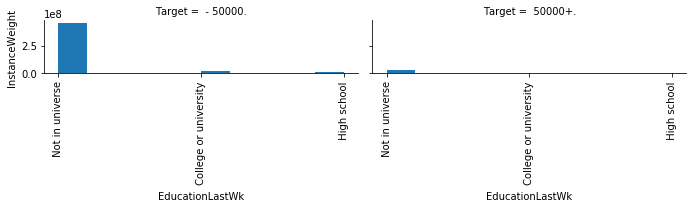

In [448]:
def weighted_hist(x, weights, **kwargs):
    plt.hist(x, weights=weights, **kwargs)
    plt.xticks(rotation=90)

grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'EducationLastWk', 'InstanceWeight')
plt.show()

In [449]:
df.drop('EducationLastWk', axis=1, inplace=True)

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


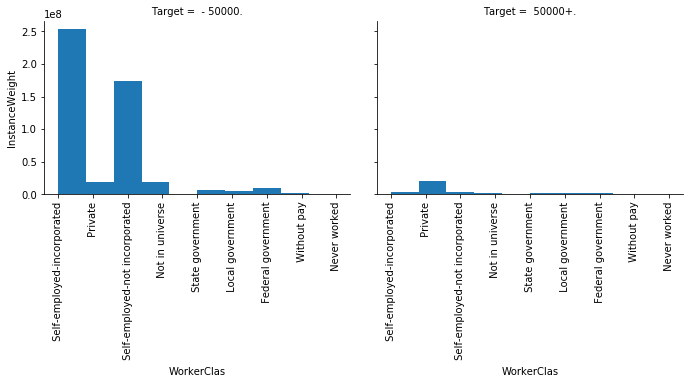

In [450]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'WorkerClas', 'InstanceWeight')
plt.show()

In [451]:
df['WorkerClas'].value_counts()

 Not in universe                   150324
 Private                           108099
 Self-employed-not incorporated     12725
 Local government                   11617
 State government                    6394
 Self-employed-incorporated          4913
 Federal government                  4330
 Never worked                         643
 Without pay                          240
Name: WorkerClas, dtype: int64

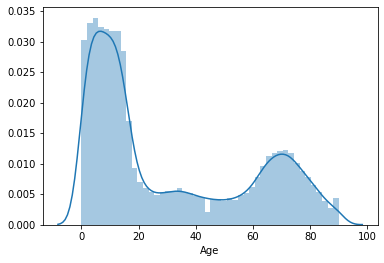

In [452]:
from scipy import stats
niuWCLen = df.loc[(df['WorkerClas']==' Not in universe')].shape[0]
avgAgeWCNIU = df.loc[df['WorkerClas']==' Not in universe', 'Age']

sns.distplot(avgAgeWCNIU)
plt.show()
# we can say that the not in universe for worker class are unemployed

In [453]:
# see age with respect to worker class
df.loc[df['Age'] < 18].WorkerClas.value_counts()

 Not in universe                   79624
 Private                            3274
 Never worked                        352
 Self-employed-not incorporated      202
 Local government                    131
 Self-employed-incorporated           54
 State government                     32
 Without pay                          28
 Federal government                   14
Name: WorkerClas, dtype: int64

In [454]:
df.loc[(df['WorkerClas']==' Not in universe'), 'WorkerClas'] = ' Unemployed'

In [455]:
df['WorkerClas'].value_counts()

 Unemployed                        150324
 Private                           108099
 Self-employed-not incorporated     12725
 Local government                   11617
 State government                    6394
 Self-employed-incorporated          4913
 Federal government                  4330
 Never worked                         643
 Without pay                          240
Name: WorkerClas, dtype: int64

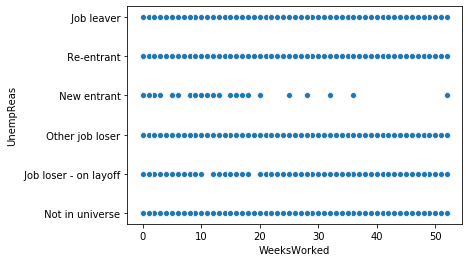

In [456]:
# if unempreason is not in universe it implies that the person has a job
# how can i check this? plot unempreason against weeksworked in past year
sns.scatterplot(y='UnempReas', x='WeeksWorked', data=df)
plt.show()
# shows the opposite, if your unempreas is not in universe you still could have worked in the past year
# but it could also mean you ve been unemployed recently and before were working before being made 'redundant'

In [457]:
# assume that for unempreason not in universe means that they are employed
df.loc[df['UnempReas']==' Not in universe', 'UnempReas'] = ' Employed'

In [458]:
df['UnempReas'].value_counts()

 Employed                 290085
 Other job loser            3146
 Re-entrant                 3043
 Job loser - on layoff      1484
 Job leaver                  884
 New entrant                 643
Name: UnempReas, dtype: int64

In [459]:
# could also bin prevreg into nomove for not in universe and other
df['PrevReg'].value_counts()

 Not in universe    275818
 South                7314
 West                 6120
 Midwest              5273
 Northeast            4027
 Abroad                733
Name: PrevReg, dtype: int64

In [460]:
df.loc[df['PrevReg']==' Not in universe', 'PrevReg'] = ' No movement'

also prevreg should be discarded since more information can be found in previous state... makes sense

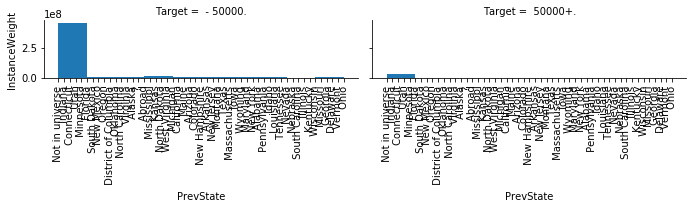

In [461]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'PrevState', 'InstanceWeight')
plt.show()

In [462]:
# what is that ? value
allstates= np.array([
    ' Alabama',
    ' Alaska',
    ' Arizona',
    ' Arkansas',
    ' California',
    ' Colorado',
    ' Connecticut',
    ' Delaware',
    ' Florida',
    ' Georgia',
    ' Hawaii',
    ' Idaho',
    ' Illinois',
    ' Indiana',
    ' Iowa',
    ' Kansas',
    ' Kentucky',
    ' Louisiana',
    ' Maine',
    ' Maryland',
    ' Massachusetts',
    ' Michigan',
    ' Minnesota',
    ' Mississippi',
    ' Missouri',
    ' Montana',
    ' Nebraska',
    ' Nevada',
    ' New Hampshire',
    ' New Jersey',
    ' New Mexico',
    ' New York',
    ' North Carolina',
    ' North Dakota',
    ' Ohio',
    ' Oklahoma',
    ' Oregon',
    ' Pennsylvania',
    ' Rhode Island',
    ' South Carolina',
    ' South Dakota',
    ' Tennessee',
    ' Texas',
    ' Utah',
    ' Vermont',
    ' Virginia',
    ' Washington',
    ' West Virginia',
    ' Wisconsin',
    ' Wyoming',
    ' Abroad'
])
uniquePrevState = df['PrevState'].unique()
np.setdiff1d(allstates, uniquePrevState)

array([' Hawaii', ' Rhode Island', ' Washington'], dtype='<U15')

In [463]:
df['PrevState'].unique()

array([' Not in universe', ' Arkansas', ' Utah', ' Michigan',
       ' Minnesota', ' Alaska', ' Kansas', ' Indiana', ' ?',
       ' Massachusetts', ' New Mexico', ' Nevada', ' Tennessee',
       ' Colorado', ' Abroad', ' Kentucky', ' California', ' Arizona',
       ' North Carolina', ' Connecticut', ' Florida', ' Vermont',
       ' Maryland', ' Oklahoma', ' Oregon', ' Ohio', ' South Carolina',
       ' Texas', ' Montana', ' Wyoming', ' Georgia', ' Pennsylvania',
       ' Iowa', ' New Hampshire', ' Missouri', ' Alabama',
       ' North Dakota', ' New Jersey', ' Louisiana', ' West Virginia',
       ' Delaware', ' Illinois', ' Maine', ' Wisconsin', ' New York',
       ' Idaho', ' District of Columbia', ' South Dakota', ' Nebraska',
       ' Virginia', ' Mississippi'], dtype=object)

In [464]:
# see proportion of ? compared to overall length
df.loc[df['PrevState']==' ?'].shape[0]/df.shape[0]
# around 0.3%

# US pop in 1995 was 266.6 million (1995)
# washington population 1995 was 5.431 million 
# set ? to washington
df.loc[df['PrevState']==' ?'].PrevReg.value_counts()
# prevreg has northeast - rhode island and south - washington

df.loc[(df['PrevState']==' ?') & (df['PrevReg']==' Northeast'), 'PrevState'] = ' Rhode Island'
df.loc[(df['PrevState']==' ?') & (df['PrevReg']==' South'), 'PrevState'] = ' Washington'

Over 42 million Americans
moved in the 1-year period
between March 1992 and
March 1993. This amounted
to 16.8 percent of the population 1 year old and over.
 Most movers stay in the
same county. In fact, about
two-thirds of the movers
between March 1992 and
March 1993 (10.5 percent
of the total population)
made such a “local” move.
 The “average American”
makes 11.7 moves in a life

From: https://www.census.gov/prod/1/pop/profile/95/p23-189.pdf

In [465]:
df.loc[df['PrevState']==' Not in universe', 'PrevState'] = ' Same state'

In [466]:
df.MigCodeMSA.value_counts()

 ?                   149642
 Nonmover            123937
 MSA to MSA           15890
 NonMSA to nonMSA      4155
 Not in universe       2239
 MSA to nonMSA         1154
 NonMSA to MSA          910
 Not identifiable       630
 Abroad to MSA          619
 Abroad to nonMSA       109
Name: MigCodeMSA, dtype: int64

In [467]:
# seems like the question marks here imply that there was no movement
df.loc[df['MigCodeMSA'] == ' ?'].PrevState.value_counts()
df.loc[df['MigCodeMSA'] == ' ?', 'MigCodeMSA'] = ' Nonmover'

In [468]:
df

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,MigResSunbelt,NumWorkersEmployer,FamMembersU18,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target
0,73,Unemployed,54,0,High school graduate,0,Widowed,White,All other,Female,No,Employed,Not in labor force,0,0,0,Nonfiler,No movement,Same state,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,Nonmover,?,?,No,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Divorced,White,All other,Male,No,Employed,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Unemployed,52,0,High School,0,Never married,Asian or Pacific Islander,All other,Female,No,Employed,Not in labor force,0,0,0,Nonfiler,No movement,Same state,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,Nonmover,?,?,No,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Unemployed,52,0,Children,0,Never married,White,All other,Female,Yes,Employed,Children or Armed Forces,0,0,0,Nonfiler,No movement,Same state,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Unemployed,52,0,Children,0,Never married,White,All other,Female,No,Employed,Children or Armed Forces,0,0,0,Nonfiler,No movement,Same state,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Unemployed,52,0,Children,0,Never married,White,All other,Female,No,Employed,Children or Armed Forces,0,0,0,Nonfiler,No movement,Same state,Child <18 never marr not in subfamily,Child under 18 never married,1708.85,Nonmover,?,?,No,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
99758,61,Private,8,36,High School Dropout,0,Separated,Black,All other,Male,No,Employed,Full-time schedules,0,0,0,Single,No movement,Same state,Nonfamily householder,Householder,2511.11,Nonmover,?,?,No,?,4,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
99759,24,Self-employed-not incorporated,1,43,High School Dropout,0,Married-civilian spouse present,White,Latino,Male,No,Employed,Children or Armed Forces,0,0,0,Joint both under 65,No movement,Same state,Spouse of RP of unrelated subfamily,Nonrelative of householder,2083.76,Nonmover,Nonmover,Nonmover,Yes,Not in universe,2,Not in universe,Mexico,Mexico,Mexico,Foreign born- U S citizen by naturalization,0,Not in universe,2,52,94,- 50000.
99760,30,Private,45,2,Bachelors degree(BA AB BS),0,Married-civilian spouse present,White,All other,Female,No,Employed,Full-time schedules,0,0,0,Joint both under 65,No movement,Same state,Spouse of householder,Spouse of householder,1680.06,Nonmover,?,?,No,?,5,Not in universe,United-States,United-States,United-States,Native- Born in the Un

In [469]:
df['MigCodeRegDiff'].value_counts()
df.loc[df['MigCodeRegDiff']==' ?', 'MigCodeRegDiff'] = ' Nonmover'

In [470]:
df.loc[df['MigCodeRegSame']== ' ?', 'MigCodeRegSame'] = ' Nonmover'

In [471]:
df['MigCodeMSA'].value_counts()

 Nonmover            273579
 MSA to MSA           15890
 NonMSA to nonMSA      4155
 Not in universe       2239
 MSA to nonMSA         1154
 NonMSA to MSA          910
 Not identifiable       630
 Abroad to MSA          619
 Abroad to nonMSA       109
Name: MigCodeMSA, dtype: int64

In [472]:
df.loc[df['MigCodeMSA']==' Not in universe'].TaxFilerStat.value_counts()

 Nonfiler                        2237
 Joint one under 65 & one 65+       1
 Joint both under 65                1
Name: TaxFilerStat, dtype: int64

In [473]:
# migcodemsa - age is 0 for all, therefore set as nonmover
df.loc[df['MigCodeMSA']==' Not in universe', 'MigCodeMSA'] = ' Nonmover'
df.loc[df['MigCodeRegDiff']==' Not in universe', 'MigCodeRegDiff'] = ' Nonmover'
df.loc[df['MigCodeRegSame']==' Not in universe', 'MigCodeRegSame'] = ' Nonmover'

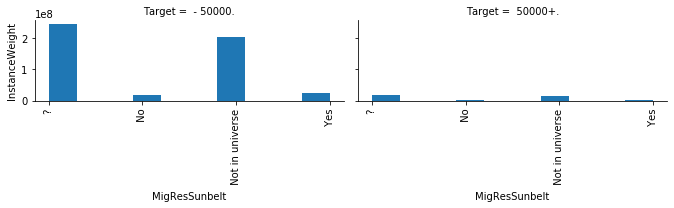

In [474]:
df['MigResSunbelt'].value_counts()

grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'MigResSunbelt', 'InstanceWeight')
plt.show()

In [475]:
df.loc[(df['Target']==' - 50000.'),'MigResSunbelt'].value_counts()

 ?                  139772
 Not in universe    118425
 No                  14146
 Yes                  8374
Name: MigResSunbelt, dtype: int64

In [476]:
df.loc[(df['Target']==' 50000+.'),'MigResSunbelt'].value_counts()

 ?                  9870
 Not in universe    7751
 No                  652
 Yes                 295
Name: MigResSunbelt, dtype: int64

In [477]:
# df.loc[(df['Target']==' 50000+.') & (df['MigResSunbelt']==' ?'), 'MigCodeMSA'].value_counts()
df.loc[(df['MigResSunbelt']==' ?'), 'MigResSunbelt'].value_counts()

 ?    149642
Name: MigResSunbelt, dtype: int64

In [478]:
# cant find any info regarding migressunbelt... dropping
df.drop('MigResSunbelt', axis=1, inplace=True)

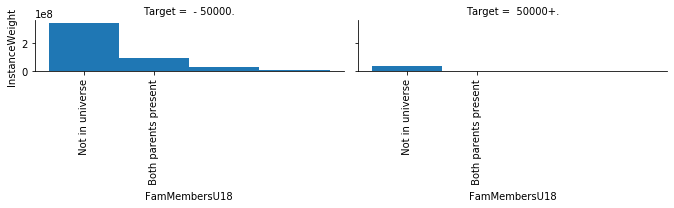

In [479]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'FamMembersU18', 'InstanceWeight', bins=np.arange(0,df['FamMembersU18'].nunique())-0.5)
plt.show()

In [480]:
df.loc[(df['FamMembersU18']==' Not in universe')]
df.drop('FamMembersU18', axis=1, inplace=True)

In [481]:
df[0:10]

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,NumWorkersEmployer,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target
0,73,Unemployed,54,0,High school graduate,0,Widowed,White,All other,Female,No,Employed,Not in labor force,0,0,0,Nonfiler,No movement,Same state,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,Nonmover,Nonmover,Nonmover,No,0,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Divorced,White,All other,Male,No,Employed,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,1,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Unemployed,52,0,High School,0,Never married,Asian or Pacific Islander,All other,Female,No,Employed,Not in labor force,0,0,0,Nonfiler,No movement,Same state,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,Nonmover,Nonmover,Nonmover,No,0,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Unemployed,52,0,Children,0,Never married,White,All other,Female,Yes,Employed,Children or Armed Forces,0,0,0,Nonfiler,No movement,Same state,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,0,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Unemployed,52,0,Children,0,Never married,White,All other,Female,No,Employed,Children or Armed Forces,0,0,0,Nonfiler,No movement,Same state,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,0,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
5,48,Private,40,10,Some college but no degree,1200,Married-civilian spouse present,Amer Indian Aleut or Eskimo,All other,Female,No,Employed,Full-time schedules,0,0,0,Joint both under 65,No movement,Same state,Spouse of householder,Spouse of householder,162.61,Nonmover,Nonmover,Nonmover,No,1,Philippines,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52,95,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Married-civilian spouse present,White,All other,Male,No,Employed,Children or Armed Forces,5178,0,0,Joint both under 65,No movement,Same state,Householder,Householder,1535.86,Nonmover,Nonmover,Nonmover,Yes,6,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
7,28,Private,4,40,High school graduate,0,Never married,White,All other,Female,No,Job loser - on layoff,Unemployed full-time,0,0,0,Single,No movement,Same state,Secondary individual,Nonrelative of householder,898.83,Nonmover,Nonmover,Nonmover,No,4,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,30,95,- 50000.
8,47,Local government,43,26,Some college but no degree,876,Married-civilian spouse present,White,All other,Female,No,Employed,Full-time schedules,0,0,0,Joint both under 65,No movement,Same state,Spouse of householder,Spouse of householder,1661.53,Nonmover,Nonmover,Nonmover,No,5,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,95,- 50000.
9,34,Private,4,37,Some college but no degree,0,Married-civilian spouse present,White,All other,Male,No,Employed,Children or Armed Forces,0,0,0,Joint both under 65,No movement,Same state,Householder,Householder,1146.79,Nonmover,Nonmover,Nonmover,Yes,6,United-St

In [482]:
df.loc[df['FatherBirthCountry']==' ?', 'FatherBirthCountry'] = df['FatherBirthCountry'].value_counts().keys()[0]
df.loc[df['MotherBirthCountry']==' ?', 'MotherBirthCountry'] = df['MotherBirthCountry'].value_counts().keys()[0]
df.loc[df['SelfBirthCountry']==' ?', 'SelfBirthCountry'] = df['SelfBirthCountry'].value_counts().keys()[0]

In [483]:
df['VeteranAdmQ'].value_counts()

 Not in universe    296274
 No                   2421
 Yes                   590
Name: VeteranAdmQ, dtype: int64

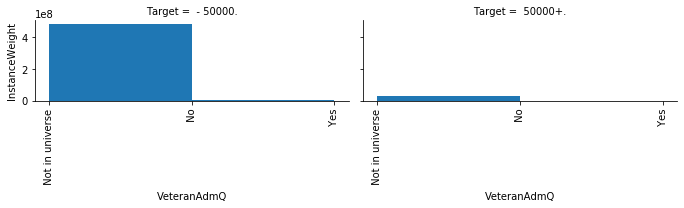

In [484]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'VeteranAdmQ', 'InstanceWeight', bins=[0,1,2])
plt.show()

In [485]:
# assuming that not in universe here means that they are not veterans
df.loc[df['VeteranAdmQ']==' Not in universe', 'VeteranAdmQ'] = ' Not veteran'

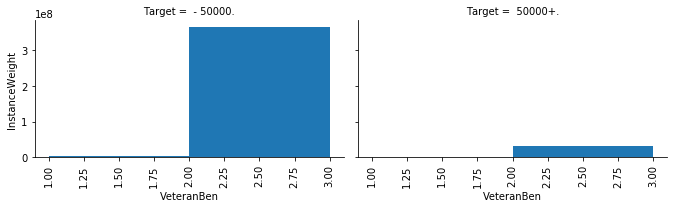

In [486]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(weighted_hist, 'VeteranBen', 'InstanceWeight', bins=[1,2,3])
plt.show()

In [487]:
# checking to make sure got rid of all
for col in df.columns:
    if (' Not in universe' in df[col].value_counts().keys()) or (' ?' in df[col].value_counts().keys()):
        print(col)

Now move onto feature engineering etc. First label encode columns and then check correlation plot.

Nominal vs Ordinal

In [488]:
from sklearn.preprocessing import LabelEncoder

def convertFeatures(data):
    for col in data.columns.values:
        if data[col].dtype.name == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])

In [489]:
convertFeatures(df)

In [490]:
df.loc[df['Wage']==0, 'Wage'] = None

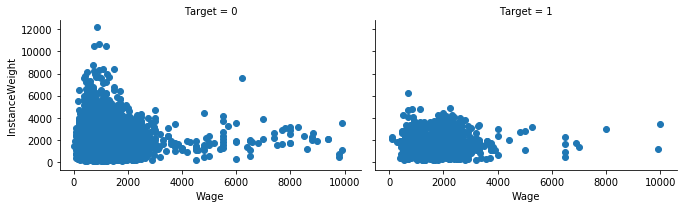

In [491]:
grid = sns.FacetGrid(df, col='Target', aspect=1.6)
grid.map(plt.scatter, 'Wage', 'InstanceWeight')
plt.show()

In [492]:
df['Wage'].describe()

count    16888.000000
mean       976.557793
std        651.346665
min         20.000000
25%        580.000000
50%        800.000000
75%       1200.000000
max       9999.000000
Name: Wage, dtype: float64

In [493]:
# what is most important to my wage feature
# do shapley ranking of wage 
def shapRanking(x_data, y_data):
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_data, y_data, test_size=0.33, random_state=42)

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    # LGB parameters:
    params = {'learning_rate': 0.05,
              'boosting': 'gbdt',
              'objective': 'binary',
              'num_leaves': 2000,
              'min_data_in_leaf': 200,
              'max_bin': 200,
              'max_depth': 16,
              'seed': 2018,
              'nthread': 10, }

    # LGB training:
    lgb_model = lgb.train(params, train_data,
                          num_boost_round=2000,
                          valid_sets=(valid_data,),
                          verbose_eval=10,
                          early_stopping_rounds=20)

    explainer = shap.TreeExplainer(lgb_model).shap_values(valid_x)
    shap.summary_plot(explainer[1], valid_x)
    plt.show()
    
# wage_df = df.drop(['Wage', 'InstanceWeight'], axis=1).loc[df['Wage']!=np.nan]
wage_df = df.loc[df['Wage'].notnull()]
wage_df_y = wage_df['Wage']

# just checking what is important to target when wage is not 0
wage_df_target = wage_df['Target']

wage_df.drop('Target', inplace=True, axis=1)

# shapRanking(wage_df, wage_df_target)
# shows that wage is important when it is there
# try knn for wages when 0

wage_df.drop(['Wage'], inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


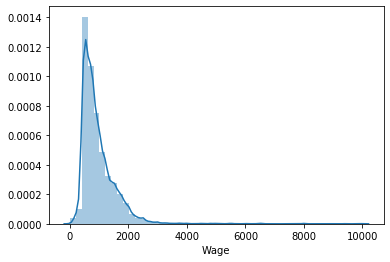

In [494]:
sns.distplot(df.loc[df['Wage'].notnull()]['Wage'])

In [495]:
from scipy import stats

# wage_list = df.loc[df['Wage'].notnull()]['Wage']
# stats.probplot(wage_list, plot=sns.mpl.pyplot)
wage_series = df.loc[df['Wage'].notnull()]['Wage'].value_counts()
# 16888 have a wage
# median is 2, mean is around 11.8
wage_series

500.0     1094
600.0      831
700.0      815
800.0      756
1000.0     599
          ... 
7800.0       1
270.0        1
1659.0       1
2085.0       1
1301.0       1
Name: Wage, Length: 1424, dtype: int64

In [506]:
# do group by on industrycode and education and apply new wage



df['Wage'] = df['Wage'].transform(lambda x: x.fillna(0))
df['Wage'] = df.groupby(['IndustryCode', 'Education', 'OccupationCode'])['Wage'].transform(lambda x: x.fillna(x.mean()))

# df.loc[df['Wage']==0].shape

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,NumWorkersEmployer,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target
0,73,7,54,0,8,0.0,6,4,0,0,0,0,2,0,0,0,4,2,40,24,5,1700.09,6,5,6,0,0,39,39,39,4,0,1,2,0,95,0
1,58,5,4,34,12,0.0,0,4,0,1,0,0,0,0,0,0,0,4,4,20,3,1053.55,2,6,7,0,1,39,39,39,4,0,1,2,52,94,0
2,18,7,52,0,6,0.0,4,1,0,0,0,0,2,0,0,0,4,2,40,2,0,991.95,6,5,6,0,0,40,40,40,0,0,1,2,0,95,0
3,9,7,52,0,3,0.0,4,4,0,0,1,0,0,0,0,0,4,2,40,8,1,1758.14,6,5,6,1,0,39,39,39,4,0,1,0,0,94,0
4,10,7,52,0,3,0.0,4,4,0,0,0,0,0,0,0,0,4,2,40,8,1,1069.16,6,5,6,1,0,39,39,39,4,0,1,0,0,94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,7,52,0,3,0.0,4,4,0,0,0,0,0,0,0,0,4,2,40,8,1,1708.85,6,5,6,0,0,39,39,39,4,0,1,0,0,95,0
99758,61,3,8,36,7,0.0,5,2,0,1,0,0,1,0,0,0,5,2,40,22,3,2511.11,6,5,6,0,4,39,39,39,4,0,1,2,52,95,0
99759,24,5,1,43,7,0.0,2,4,1,1,0,0,0,0,0,0,2,2,40,36,4,2083.76,6,5,6,1,2,25,25,25,1,0,1,2,52,94,0
99760,30,3,45,2,2,0.0,2,4,0,0,0,0,1,0,0,0,2,2,40,37,6,1680.06,6,5,6,0,5,39,39,39,4,0,1,2,52,95,0


In [508]:
df.loc[df['Wage']==0, 'Wage'] = None

In [512]:
df['Wage'] = df.groupby(['Education', 'OccupationCode'])['Wage'].transform(lambda x: x.fillna(x.mean()))

In [518]:
# from sklearn.impute import KNNImputer

df.loc[df['Wage'].isnull(), 'Wage'] = 0
df_ninetyfifth = df.loc[df['Wage'] < df['Wage'].quantile(0.95)]

#  using groupby averages (ie filled in) to train knn and fill in others where 0
df_ninetyfifth_wage = df_ninetyfifth.loc[df_ninetyfifth['Wage']!=0]
df_ninetyfifth_wage

,Age,WorkerClas,IndustryCode,OccupationCode,Education,Wage,MaritalStat,Race,HispOrig,Sex,LabourUnion,UnempReas,FullPartStat,CapGains,CapLosses,StockDiv,TaxFilerStat,PrevReg,PrevState,HouseholdFamStat,HouseholdSummaryStat,InstanceWeight,MigCodeMSA,MigCodeRegDiff,MigCodeRegSame,HouseLive1Yr,NumWorkersEmployer,FatherBirthCountry,MotherBirthCountry,SelfBirthCountry,Cit,BusinessOwner,VeteranAdmQ,VeteranBen,WeeksWorked,Yr,Target
1,58,5,4,34,12,1375.619718,0,4,0,1,0,0,0,0,0,0,0,4,4,20,3,1053.55,2,6,7,0,1,39,39,39,4,0,1,2,52,94,0
5,48,3,40,10,12,1200.000000,2,0,0,0,0,0,1,0,0,0,2,2,40,37,6,162.61,6,5,6,0,1,30,39,39,4,2,1,2,52,95,0
6,42,3,34,3,2,1344.528090,2,4,0,1,0,0,0,5178,0,0,2,2,40,20,3,1535.86,6,5,6,1,6,39,39,39,4,0,1,2,52,94,0
7,28,3,4,40,8,965.727273,4,4,0,0,0,2,6,0,0,0,5,2,40,35,4,898.83,6,5,6,0,4,39,39,39,4,0,1,2,30,95,0
8,47,1,43,26,12,876.000000,2,4,0,0,0,0,1,0,0,0,2,2,40,37,6,1661.53,6,5,6,0,5,39,39,39,4,0,1,2,52,95,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99752,46,3,44,3,12,1028.965517,2,2,0,0,0,0,1,0,0,0,2,2,40,37,6,1197.34,6,5,6,0,1,39,39,39,4,0,1,2,52,95,0
99754,17,3,33,29,6,451.438525,4,4,0,0,0,0,1,0,0,0,4,2,40,8,1,1414.11,6,5,6,0,6,39,39,39,4,0,1,2,1,95,0
99758,61,3,8,36,7,819.096000,5,2,0,1,0,0,1,0,0,0,5,2,40,22,3,2511.11,6,5,6,0,4,39,39,39,4,0,1,2,52,95,0
99759,24,5,1,43,7,475.000000,2,4,1,1,0,0,0,0,0,0,2,2,40,36,4,2083.76,6,5,6,1,2,25,25,25,1,0,1,2,52,94,0


In [524]:
from sklearn.neighbors import KNeighborsRegressor

df_ninetyfifth_wage_y = df_ninetyfifth_wage['Wage']
df_ninetyfifth_wage.drop(['InstanceWeight', 'Wage', 'Target'], axis=1, inplace=True)

# fit knn regressor on data that has wage (orig + groupby)
neig = KNeighborsRegressor(n_neighbors=10)
neig.fit(df_ninetyfifth_wage, df_ninetyfifth_wage_y)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [531]:
# predict where wages are 0
df.loc[df['Wage']==0, 'Wage'] = neig.predict(df.loc[df['Wage']==0].drop(['InstanceWeight', 'Wage', 'Target'], axis=1))
# remove irrelevant columns and perform prediction here  
# see that values remain within the 95th percentile and inspect visually
# then rerun correlation plot seen later on

In [534]:
# set all those that arent of working age to have 0 wage
df.loc[(df['Age'] > 16) & (df['Age'] <= 65), 'Wage'] = 0

# not employed therefore should have 0 wage
df.loc[(df['UnempReas']!=0), 'Wage'] = 0

In [549]:
df['UnempReas'].value_counts()

0    290085
4      3146
5      3043
2      1484
1       884
3       643
Name: UnempReas, dtype: int64

In [537]:
df_new_y = df['Target']
df_new = df.drop(['Target', 'InstanceWeight'], axis=1)
# shapRanking(df_new, df_new_y)

# Feature Ranking

In [538]:
df_rank_test = df.drop(['InstanceWeight'], axis=1)
df_rank_test_y = df_rank_test['Target']
df_rank_test.drop(['Target'], axis=1, inplace=True)

In [422]:
from sklearn.feature_selection import RFE, SelectKBest, chi2, mutual_info_classif

def recursiveFeatureElim(x_data, y_data):
    # using recursive feature elimination
    estimator = LogisticRegression(solver='lbfgs')
    selector = RFE(estimator, 10, step=1)
    selector = selector.fit(x_data, y_data)
    print(selector.ranking_)
    print(x_data.columns.values)
    print(selector.n_features_)    
    
recursiveFeatureElim(df_rank_test, df_rank_test_y)

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

[10  3 17  5 11 24  2  1  1  1  1 14 18 26 23 25  1  6 22 13 12  4  1  1
  7  1 20 21 19 15 16  1  1  9  8]
['Age' 'WorkerClas' 'IndustryCode' 'OccupationCode' 'Education' 'Wage'
 'MaritalStat' 'Race' 'HispOrig' 'Sex' 'LabourUnion' 'UnempReas'
 'FullPartStat' 'CapGains' 'CapLosses' 'StockDiv' 'TaxFilerStat' 'PrevReg'
 'PrevState' 'HouseholdFamStat' 'HouseholdSummaryStat' 'MigCodeMSA'
 'MigCodeRegDiff' 'MigCodeRegSame' 'HouseLive1Yr' 'NumWorkersEmployer'
 'FatherBirthCountry' 'MotherBirthCountry' 'SelfBirthCountry' 'Cit'
 'BusinessOwner' 'VeteranAdmQ' 'VeteranBen' 'WeeksWorked' 'Yr']
10


Feature WorkerClas: 10759.035125
Feature IndustryCode: 37708.484235
Feature OccupationCode: 1044.816873
Feature Education: 81.579417
Feature MaritalStat: 4646.504706
Feature Race: 112.529972
Feature HispOrig: 1419.259655
Feature Sex: 3885.663306
Feature LabourUnion: 511.001865
Feature UnempReas: 729.984808
Feature FullPartStat: 237.771268
Feature TaxFilerStat: 3398.905543
Feature PrevReg: 9.109281
Feature PrevState: 85.165042
Feature HouseholdFamStat: 12143.674445
Feature HouseholdSummaryStat: 1764.087154
Feature MigCodeMSA: 18.761189
Feature MigCodeRegDiff: 0.032687
Feature MigCodeRegSame: 0.015521
Feature HouseLive1Yr: 0.529557
Feature FatherBirthCountry: 176.896706
Feature MotherBirthCountry: 127.599666
Feature SelfBirthCountry: 27.004065
Feature Cit: 19.564841
Feature BusinessOwner: 892.844783
Feature VeteranAdmQ: 2.160930
Feature VeteranBen: 2815.095013
Feature Yr: 0.208670


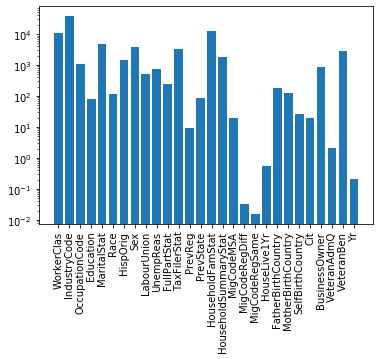

In [423]:
def chiSquare(x_data, y_data):
    # using chisquare test - only for categorical vars, higher implies greater independence
    chiData = x_data.drop(['Age', 'Wage', 'CapGains', 'CapLosses', 'StockDiv', 'NumWorkersEmployer', 'WeeksWorked'], axis=1)
    selector = SelectKBest(score_func=chi2, k='all')
    selector.fit(chiData, y_data)
    fs_res = selector.transform(chiData)
    for i in range(len(selector.scores_)):
        print('Feature %s: %f' % (chiData.columns.values[i], selector.scores_[i]))

    bar = plt.bar([i for i in range(len(selector.scores_))], selector.scores_, log=True)
    plt.xticks(ticks=np.arange(len(chiData.columns.values)), labels=chiData.columns.values, rotation=90)
    plt.show()
    
chiSquare(df_rank_test, df_rank_test_y)

Feature Age: 0.038028
Feature WorkerClas: 0.055557
Feature IndustryCode: 0.051233
Feature OccupationCode: 0.065478
Feature Education: 0.065881
Feature Wage: 0.054342
Feature MaritalStat: 0.047367
Feature Race: 0.053537
Feature HispOrig: 0.002788
Feature Sex: 0.027038
Feature LabourUnion: 0.000698
Feature UnempReas: 0.000547
Feature FullPartStat: 0.017065
Feature CapGains: 0.027173
Feature CapLosses: 0.012122
Feature StockDiv: 0.028034
Feature TaxFilerStat: 0.055241
Feature PrevReg: 0.053182
Feature PrevState: 0.061917
Feature HouseholdFamStat: 0.047280
Feature HouseholdSummaryStat: 0.046285
Feature MigCodeMSA: 0.052490
Feature MigCodeRegDiff: 0.061682
Feature MigCodeRegSame: 0.050191
Feature HouseLive1Yr: 0.010660
Feature NumWorkersEmployer: 0.039549
Feature FatherBirthCountry: 0.056275
Feature MotherBirthCountry: 0.057664
Feature SelfBirthCountry: 0.062829
Feature Cit: 0.058673
Feature BusinessOwner: 0.002823
Feature VeteranAdmQ: 0.065532
Feature VeteranBen: 0.064282
Feature WeeksWork

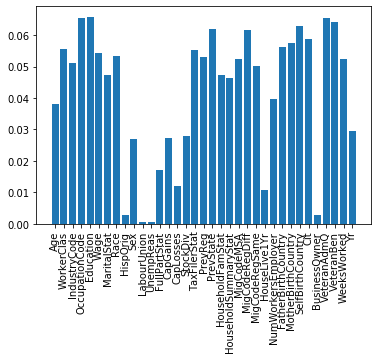

In [424]:
def mutualInfoRanking(x_data, y_data):
    # using mutual information feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k='all')
    selector.fit(x_data, y_data)
    selector.transform(x_data)
    for i in range(len(selector.scores_)):
        print('Feature %s: %f' % (x_data.columns.values[i], selector.scores_[i]))

    bar = plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
    plt.xticks(ticks=np.arange(len(x_data.columns.values)), labels=x_data.columns.values, rotation=90)
    plt.show()
    
mutualInfoRanking(df_rank_test, df_rank_test_y)

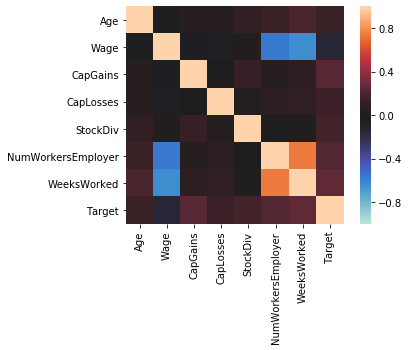

In [539]:
def continuousCorrelation(data):
    data = data[['Age', 'Wage', 'CapGains', 'CapLosses', 'StockDiv', 'NumWorkersEmployer', 'WeeksWorked', 'Target']]
    corr = data.corr()
    hm = sns.heatmap(corr, vmin=-1, vmax=1, center=0, square=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
    plt.show()
    
continuousCorrelation(pd.concat([df_rank_test, df_rank_test_y], axis=1))

# Modelling Portion 

In [542]:
df.drop(['InstanceWeight'], axis=1, inplace=True)

In [543]:
train = df[0:train_len]
test = df[train_len:(train_len + test_len)]

In [544]:
train_y = train['Target']
train.drop(['Target'], axis=1, inplace=True)
test_y = test['Target']
test.drop(['Target'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [545]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [271]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
reg = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=500, random_state=123)
cross_val_score(reg, train, train_y, cv=kf)
preds = cross_val_predict(reg, test, test_y, cv=kf)
print('Accuracy Logistic Reg: ', (accuracy_score(preds, test_y)) * 100)
print('AOC ROC ', roc_auc_score(test_y.values, cross_val_predict(reg, test, test_y, cv=kf, method='predict_proba')[:,1]))

lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge

Accuracy Logistic Reg:  94.6643010364668


lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.
lbfgs failed to converge. Increase the number of iterations.


AOC ROC  0.9191512582389016


lbfgs failed to converge. Increase the number of iterations.


In [550]:
import lightgbm as lgb

def lightGBMModel(x_data, y_data, x_test, y_test):
    # using lightgbm model to compare accuracy with normal rand forest
    train_x, valid_x, train_y, valid_y = train_test_split(
        x_data, y_data, test_size=0.33)

    train_data = lgb.Dataset(train_x, label=train_y)
    valid_data = lgb.Dataset(valid_x, label=valid_y)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
#         'metric': {'l2', 'l1'},
        'metric': 'auc',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'max_depth': 28,
        'num_estimators': 800
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets=valid_data,
                    early_stopping_rounds=50)

    print('Starting predicting...')
    # predict
    y_prob = gbm.predict(x_test.values, num_iteration=gbm.best_iteration)
    y_pred = [round(x) for x in y_prob]
    print('Accuracy LGBM: ', (accuracy_score(y_pred, y_test)) * 100)
    print('AOC ROC ', roc_auc_score(y_test.values, y_prob))

In [551]:
lightGBMModel(train, train_y, test, test_y)

Starting training...
[1]	valid_0's auc: 0.909904
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.913689
[3]	valid_0's auc: 0.917588
[4]	valid_0's auc: 0.929169
[5]	valid_0's auc: 0.932491
[6]	valid_0's auc: 0.934245
[7]	valid_0's auc: 0.934897
[8]	valid_0's auc: 0.934919
[9]	valid_0's auc: 0.93495
[10]	valid_0's auc: 0.936745
[11]	valid_0's auc: 0.937555
[12]	valid_0's auc: 0.938312
[13]	valid_0's auc: 0.938548
[14]	valid_0's auc: 0.938617
[15]	valid_0's auc: 0.938743
[16]	valid_0's auc: 0.938935
[17]	valid_0's auc: 0.939146
[18]	valid_0's auc: 0.939327
[19]	valid_0's auc: 0.939355
[20]	valid_0's auc: 0.940034
[21]	valid_0's auc: 0.940215
[22]	valid_0's auc: 0.940456
[23]	valid_0's auc: 0.940558
[24]	valid_0's auc: 0.94066
[25]	valid_0's auc: 0.941066
[26]	valid_0's auc: 0.94135
[27]	valid_0's auc: 0.941698
[28]	valid_0's auc: 0.94208
[29]	valid_0's auc: 0.942278
[30]	valid_0's auc: 0.942487
[31]	valid_0's auc: 0.942879
[32]	valid_0's auc: 0.943343
[33